In [1]:
# !pip install numpy
# !pip install matplotlib
# !pip install scipy

In [2]:
import numpy as np
import math
from scipy.optimize import linear_sum_assignment
import matplotlib.pyplot as plt

In [3]:
requests = [
    10.0, 10.909090909090908, 11.818181818181818, 12.727272727272727,
    13.636363636363637, 14.545454545454545, 15.454545454545453,
    16.363636363636363, 17.272727272727273, 18.18181818181818,
    19.09090909090909, 20.0, 20.909090909090907, 21.81818181818182,
    22.727272727272727, 23.636363636363637, 24.545454545454547,
    25.454545454545453, 26.363636363636363, 27.272727272727273,
    28.18181818181818, 29.09090909090909, 30.0, 30.90909090909091,
    31.818181818181817, 32.72727272727273, 33.63636363636364, 34.54545454545455,
    35.45454545454545, 36.36363636363636, 37.27272727272727, 38.18181818181818,
    39.09090909090909, 40.0, 40.90909090909091, 41.81818181818181,
    42.72727272727273, 43.63636363636363, 44.54545454545455, 45.45454545454545,
    46.36363636363636, 47.27272727272727, 48.18181818181818, 49.090909090909086,
    50.0, 50.90909090909091, 51.81818181818182, 52.72727272727273,
    53.63636363636363, 54.54545454545455, 55.45454545454545, 56.36363636363636,
    57.27272727272727, 58.18181818181818, 59.090909090909086, 60.0,
    60.90909090909091, 61.81818181818181, 62.72727272727273, 63.63636363636363,
    64.54545454545455, 65.45454545454545, 66.36363636363636, 67.27272727272728,
    68.18181818181819, 69.0909090909091, 70.0, 70.9090909090909,
    71.81818181818181, 72.72727272727272, 73.63636363636363, 74.54545454545455,
    75.45454545454545, 76.36363636363636, 77.27272727272727, 78.18181818181817,
    79.0909090909091, 80.0, 80.9090909090909, 81.81818181818181,
    82.72727272727272, 83.63636363636364, 84.54545454545455, 85.45454545454545,
    86.36363636363636, 87.27272727272727, 88.18181818181817, 89.0909090909091,
    90.0, 90.9090909090909, 91.81818181818181, 92.72727272727272,
    93.63636363636364, 94.54545454545455, 95.45454545454545, 96.36363636363636,
    97.27272727272727, 98.18181818181817, 99.0909090909091, 100.0
  ]

height = round(math.sqrt(1.05 * np.sum(requests) / 1.6), 2)
width = round(height * 1.6, 2)

In [4]:
def factor_pairs(x):
    pairs = []
    limit = int(abs(x) ** 0.5) + 1
    for i in range(1, limit):
        if x % i == 0:
            pairs.append((i, x // i))
    return pairs


def calculate_piece_areas(x_cuts, y_cuts):
    x_coords = np.sort(np.concatenate(([0], x_cuts, [width])))
    y_coords = np.sort(np.concatenate(([0], y_cuts, [height])))
    
    piece_widths = np.diff(x_coords)
    piece_heights = np.diff(y_coords)
    
    areas = np.concatenate(np.outer(piece_widths, piece_heights))
    
    return areas


def loss_function(areas, requests, tolerance=0):
    R = requests
    V = areas

    num_requests = len(R)
    num_values = len(V)

    cost_matrix = np.zeros((num_requests, num_values))

    for i, r in enumerate(R):
        for j, v in enumerate(V):
            cost_matrix[i][j] = max(abs(r - v) / r - tolerance, 0)

    row_indices, col_indices = linear_sum_assignment(cost_matrix)

    total_cost = sum(
        cost_matrix[row_indices[i], col_indices[i]] for i in range(len(row_indices))
    )

    return total_cost


def calculate_gradient(x_cuts, y_cuts, requests, curr_loss, epsilon=1e-3):
    grad_x_cuts = np.zeros_like(x_cuts, dtype=float)
    grad_y_cuts = np.zeros_like(y_cuts, dtype=float)
    
    for i in range(len(x_cuts)):
        x_cuts_eps = x_cuts.copy()
        x_cuts_eps[i] += epsilon
        areas_eps = calculate_piece_areas(x_cuts_eps, y_cuts)
        loss_eps = loss_function(areas_eps, requests)
        grad_x_cuts[i] = (loss_eps - curr_loss) / epsilon
    
    for i in range(len(y_cuts)):
        y_cuts_eps = y_cuts.copy()
        y_cuts_eps[i] += epsilon
        areas_eps = calculate_piece_areas(x_cuts, y_cuts_eps)
        loss_eps = loss_function(areas_eps, requests)
        grad_y_cuts[i] = (loss_eps - curr_loss) / epsilon
    
    return grad_x_cuts, grad_y_cuts


In [5]:
def gradient_descent(factors, learning_rate=0.1, num_iterations=200, epsilon=1e-3, learning_rate_decay=1, tolerance=0):
    best_loss = float("inf")
    best_x_cuts = None
    best_y_cuts = None
    all_losses = []

    for factor in factors:
        # print(f"Factor pair: {factor}")
        num_horizontal, num_vertical = factor

        x_cuts = np.array(np.random.randint(1, width, num_vertical), dtype=float)
        y_cuts = np.array(np.random.randint(1, height, num_horizontal), dtype=float)

        best_x_cuts = x_cuts.copy()
        best_y_cuts = y_cuts.copy()

        losses = []
        lr = learning_rate
        for i in range(num_iterations):
            lr = max(lr * learning_rate_decay, 1e-2)

            areas = calculate_piece_areas(x_cuts, y_cuts)
            loss = loss_function(areas, requests, tolerance)
            losses.append(loss)
            
            if loss < best_loss:
                best_loss = loss
                best_x_cuts = x_cuts.copy()
                best_y_cuts = y_cuts.copy()
            
            grad_x_cuts, grad_y_cuts = calculate_gradient(x_cuts, y_cuts, requests, loss, epsilon)
            
            x_cuts -= lr * grad_x_cuts
            y_cuts -= lr * grad_y_cuts
            # print(f'Iteration {i + 1}: Loss = {loss}, Best loss = {best_loss}')
        all_losses.append(losses)
    all_losses = np.array(all_losses)
    
    return best_x_cuts, best_y_cuts, all_losses

#### Constant learning rates

Best loss: 0.8846853455979187


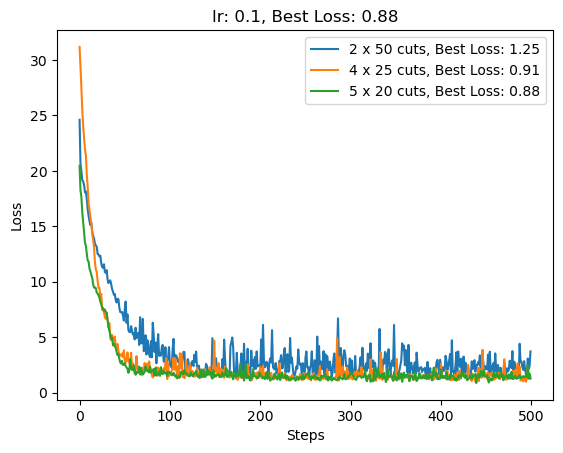

In [6]:
learning_rate = 0.1
num_iterations = 500
epsilon = 1e-3

factors = factor_pairs(len(requests))[1:-1]
best_x_cuts, best_y_cuts, all_losses = gradient_descent(factors, learning_rate, num_iterations, epsilon)

print("Best loss:", np.min(np.concatenate(all_losses)))

plt.figure()
for losses in all_losses:
    plt.plot(losses)

plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title(f'lr: {learning_rate}, Best Loss: {np.min(np.concatenate(all_losses)):.2f}')
plt.legend([f'{num_horizontal} x {num_vertical} cuts, Best Loss: {np.min(all_losses[i]):.2f}' for i, (num_horizontal, num_vertical) in enumerate(factors)])
plt.savefig(f'lr={learning_rate}_loss={np.min(np.concatenate(all_losses)):.2f}.png')
plt.show()

Best loss: 1.2636101002522067


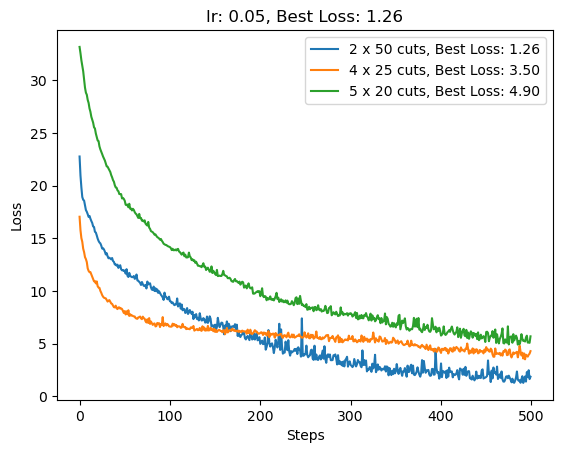

In [7]:
learning_rate = 0.05
num_iterations = 500
epsilon = 1e-3

factors = factor_pairs(len(requests))[1:-1]
best_x_cuts, best_y_cuts, all_losses = gradient_descent(factors, learning_rate, num_iterations, epsilon)

print("Best loss:", np.min(np.concatenate(all_losses)))

plt.figure()
for losses in all_losses:
    plt.plot(losses)

plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title(f'lr: {learning_rate}, Best Loss: {np.min(np.concatenate(all_losses)):.2f}')
plt.legend([f'{num_horizontal} x {num_vertical} cuts, Best Loss: {np.min(all_losses[i]):.2f}' for i, (num_horizontal, num_vertical) in enumerate(factors)])
plt.savefig(f'lr={learning_rate}_loss={np.min(np.concatenate(all_losses)):.2f}.png')
plt.show()

Best loss: 8.124802237570828


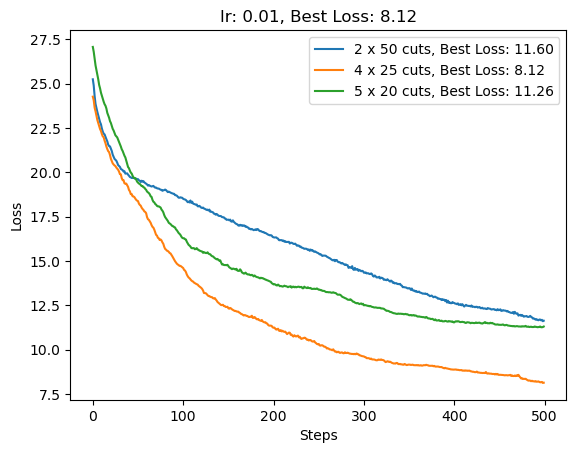

In [8]:
learning_rate = 0.01
num_iterations = 500
epsilon = 1e-3

factors = factor_pairs(len(requests))[1:-1]
best_x_cuts, best_y_cuts, all_losses = gradient_descent(factors, learning_rate, num_iterations, epsilon)

print("Best loss:", np.min(np.concatenate(all_losses)))

plt.figure()
for losses in all_losses:
    plt.plot(losses)

plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title(f'lr: {learning_rate}, Best Loss: {np.min(np.concatenate(all_losses)):.2f}')
plt.legend([f'{num_horizontal} x {num_vertical} cuts, Best Loss: {np.min(all_losses[i]):.2f}' for i, (num_horizontal, num_vertical) in enumerate(factors)])
plt.savefig(f'lr={learning_rate}_loss={np.min(np.concatenate(all_losses)):.2f}.png')
plt.show()

#### Decaying learning rates

Best loss: 1.1448348349178343


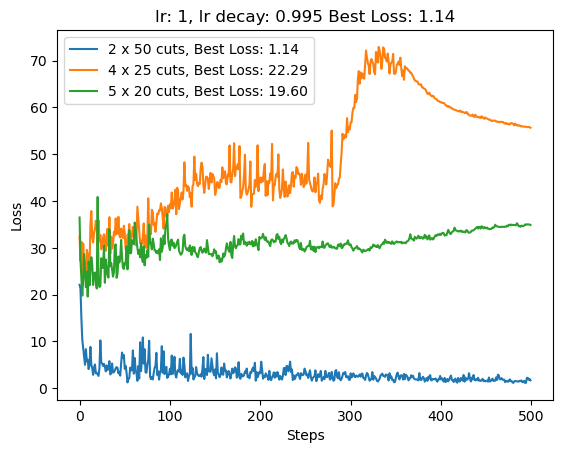

In [9]:
learning_rate = 1
learning_rate_decay = 0.995
num_iterations = 500
epsilon = 1e-3

factors = factor_pairs(len(requests))[1:-1]
best_x_cuts, best_y_cuts, all_losses = gradient_descent(factors, learning_rate, num_iterations, epsilon, learning_rate_decay)

print("Best loss:", np.min(np.concatenate(all_losses)))

plt.figure()
for losses in all_losses:
    plt.plot(losses)

plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title(f'lr: {learning_rate}, lr decay: {learning_rate_decay} Best Loss: {np.min(np.concatenate(all_losses)):.2f}')
plt.legend([f'{num_horizontal} x {num_vertical} cuts, Best Loss: {np.min(all_losses[i]):.2f}' for i, (num_horizontal, num_vertical) in enumerate(factors)])
plt.savefig(f'lr={learning_rate}_decay={learning_rate_decay}_loss={np.min(np.concatenate(all_losses)):.2f}.png')
plt.show()

Best loss: 0.4277567475713755


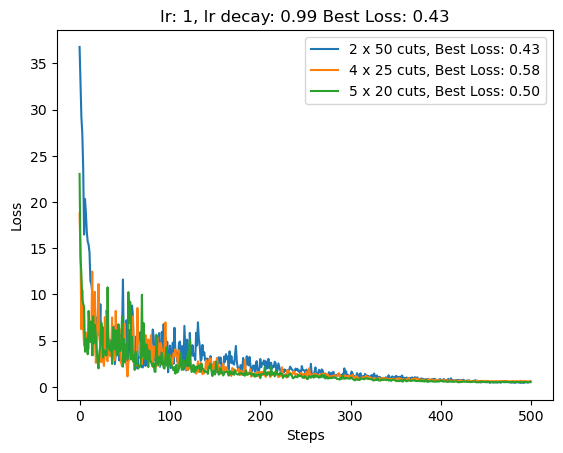

In [10]:
learning_rate = 1
learning_rate_decay = 0.99
num_iterations = 500
epsilon = 1e-3

factors = factor_pairs(len(requests))[1:-1]
best_x_cuts, best_y_cuts, all_losses = gradient_descent(factors, learning_rate, num_iterations, epsilon, learning_rate_decay)

print("Best loss:", np.min(np.concatenate(all_losses)))

plt.figure()
for losses in all_losses:
    plt.plot(losses)

plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title(f'lr: {learning_rate}, lr decay: {learning_rate_decay} Best Loss: {np.min(np.concatenate(all_losses)):.2f}')
plt.legend([f'{num_horizontal} x {num_vertical} cuts, Best Loss: {np.min(all_losses[i]):.2f}' for i, (num_horizontal, num_vertical) in enumerate(factors)])
plt.savefig(f'lr={learning_rate}_decay={learning_rate_decay}_loss={np.min(np.concatenate(all_losses)):.2f}.png')
plt.show()

Best loss: 0.5378158075788341


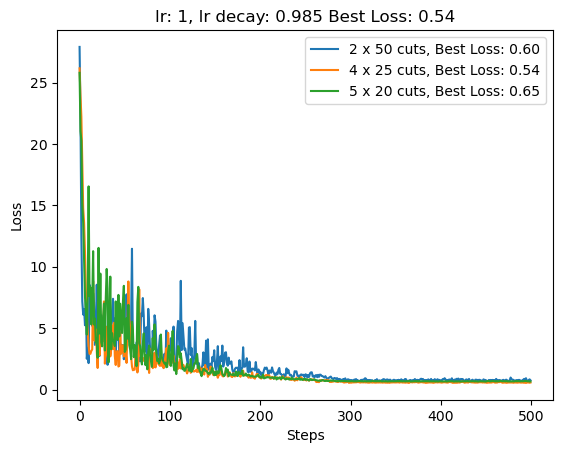

In [11]:
learning_rate = 1
learning_rate_decay = 0.985
num_iterations = 500
epsilon = 1e-3

factors = factor_pairs(len(requests))[1:-1]
best_x_cuts, best_y_cuts, all_losses = gradient_descent(factors, learning_rate, num_iterations, epsilon, learning_rate_decay)

print("Best loss:", np.min(np.concatenate(all_losses)))

plt.figure()
for losses in all_losses:
    plt.plot(losses)

plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title(f'lr: {learning_rate}, lr decay: {learning_rate_decay} Best Loss: {np.min(np.concatenate(all_losses)):.2f}')
plt.legend([f'{num_horizontal} x {num_vertical} cuts, Best Loss: {np.min(all_losses[i]):.2f}' for i, (num_horizontal, num_vertical) in enumerate(factors)])
plt.savefig(f'lr={learning_rate}_decay={learning_rate_decay}_loss={np.min(np.concatenate(all_losses)):.2f}.png')
plt.show()

Best loss: 0.40498471057885166


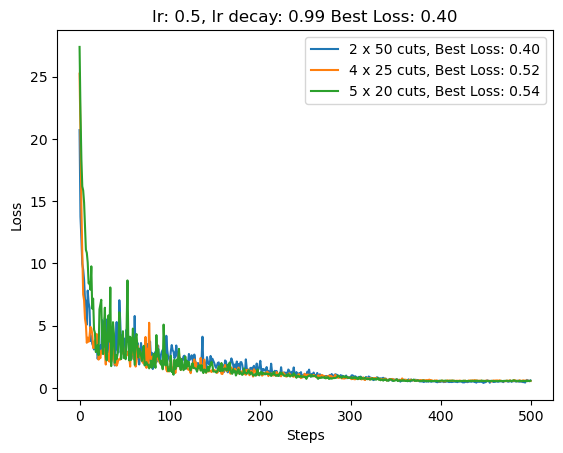

In [12]:
learning_rate = 0.5
learning_rate_decay = 0.99
num_iterations = 500
epsilon = 1e-3

factors = factor_pairs(len(requests))[1:-1]
best_x_cuts, best_y_cuts, all_losses = gradient_descent(factors, learning_rate, num_iterations, epsilon, learning_rate_decay)

print("Best loss:", np.min(np.concatenate(all_losses)))

plt.figure()
for losses in all_losses:
    plt.plot(losses)

plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title(f'lr: {learning_rate}, lr decay: {learning_rate_decay} Best Loss: {np.min(np.concatenate(all_losses)):.2f}')
plt.legend([f'{num_horizontal} x {num_vertical} cuts, Best Loss: {np.min(all_losses[i]):.2f}' for i, (num_horizontal, num_vertical) in enumerate(factors)])
plt.savefig(f'lr={learning_rate}_decay={learning_rate_decay}_loss={np.min(np.concatenate(all_losses)):.2f}.png')
plt.show()

Best loss: 1.3637742466478282


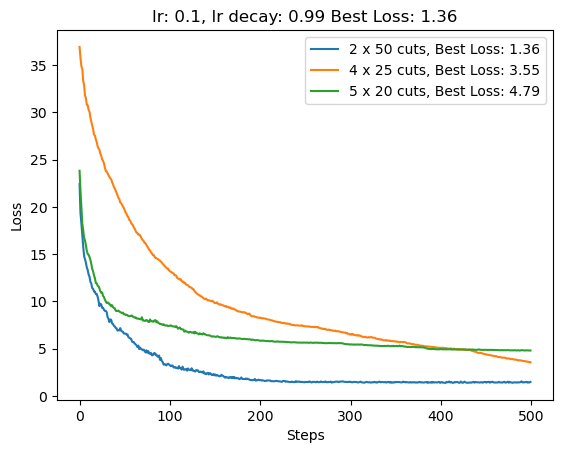

In [13]:
learning_rate = 0.1
learning_rate_decay = 0.99
num_iterations = 500
epsilon = 1e-3

factors = factor_pairs(len(requests))[1:-1]
best_x_cuts, best_y_cuts, all_losses = gradient_descent(factors, learning_rate, num_iterations, epsilon, learning_rate_decay)

print("Best loss:", np.min(np.concatenate(all_losses)))

plt.figure()
for losses in all_losses:
    plt.plot(losses)

plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title(f'lr: {learning_rate}, lr decay: {learning_rate_decay} Best Loss: {np.min(np.concatenate(all_losses)):.2f}')
plt.legend([f'{num_horizontal} x {num_vertical} cuts, Best Loss: {np.min(all_losses[i]):.2f}' for i, (num_horizontal, num_vertical) in enumerate(factors)])
plt.savefig(f'lr={learning_rate}_decay={learning_rate_decay}_loss={np.min(np.concatenate(all_losses)):.2f}.png')
plt.show()